In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:

# Define image transformations
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Model architectures
def create_defect_model(num_classes=2):
    """Create defect classification model architecture"""
    model = models.resnet50(pretrained=False)
    
    for name, param in model.named_parameters():
        if 'layer3' in name or 'layer4' in name or 'fc' in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 512),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256, num_classes)
    )
    return model


In [3]:

def create_quality_model(num_classes=2):
    """Create good/defective classification model architecture"""
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    return model


In [4]:
# Load trained model
def load_model(model_path, model_type='defect'):
    """
    Load a trained model
    """
    if not os.path.exists(model_path):
        print(f"❌ Error: Model file '{model_path}' not found!")
        return None
    
    try:
        if model_type == 'defect':
            model = create_defect_model(2)
            class_names = ['Cracks_and_fractures', 'Surface_deformation']
        else:
            model = create_quality_model(2)
            class_names = ['Defect_coal', 'Good_quality_coal']
        
        model.load_state_dict(torch.load(model_path, map_location=device))
        model = model.to(device)
        model.eval()
        
        print(f"✅ Model loaded successfully: {model_type} classification")
        print(f"📊 Classes: {class_names}")
        return model, class_names
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None

# Prediction function
def predict_image(image, model, class_names):
    """
    Make prediction on image
    """
    # Preprocess image
    image_tensor = data_transforms(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item()
    all_probabilities = probabilities.cpu().numpy()[0]
    
    return predicted_class, confidence_score, all_probabilities

# Display results
def display_results(image, predicted_class, confidence, probabilities, class_names, title="Prediction Results"):
    """
    Display image and prediction results
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Display image
    ax1.imshow(image)
    ax1.set_title(f'{title}\nPredicted: {predicted_class}\nConfidence: {confidence:.4f}', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.axis('off')
    
    # Display probabilities
    colors = ['green' if class_names[i] == predicted_class else 'blue' for i in range(len(class_names))]
    bars = ax2.bar(class_names, probabilities, color=colors, alpha=0.7)
    ax2.set_title('Classification Probabilities', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Probability')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add probability values on bars
    for bar, prob in zip(bars, probabilities):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{prob:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


In [5]:
# Test from image file
def test_from_file(image_path, model, class_names):
    """
    Test model with local image file
    """
    if not os.path.exists(image_path):
        print(f"❌ Error: Image file '{image_path}' not found!")
        return None
    
    try:
        print(f"📁 Loading image: {os.path.basename(image_path)}")
        image = Image.open(image_path).convert('RGB')
        
        predicted_class, confidence, probabilities = predict_image(image, model, class_names)
        
        # Display results
        display_results(image, predicted_class, confidence, probabilities, class_names)
        
        # Print results
        print("\n" + "="*50)
        print("📋 PREDICTION RESULTS")
        print("="*50)
        print(f"📷 Image: {os.path.basename(image_path)}")
        print(f"🎯 Predicted Class: {predicted_class}")
        print(f"📈 Confidence: {confidence:.4f}")
        print("\n📊 Probabilities:")
        for class_name, prob in zip(class_names, probabilities):
            print(f"   {class_name}: {prob:.4f}")
        print("="*50)
        
        return {
            'predicted_class': predicted_class,
            'confidence': confidence,
            'probabilities': probabilities
        }
        
    except Exception as e:
        print(f"❌ Error processing image: {e}")
        return None


In [6]:
# Test from camera
def test_from_camera(model, class_names):
    """
    Test model using laptop camera
    """
    # Initialize camera
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("❌ Error: Could not open camera!")
        return
    
    print("\n📷 Camera Controls:")
    print("   • Press 'c' to CAPTURE and analyze")
    print("   • Press 's' to SAVE the captured image")
    print("   • Press 'r' to RESET analysis")
    print("   • Press 'q' to QUIT")
    
    captured_frame = None
    analysis_results = None
    saved_images_count = 0
    output_dir = "camera_captures"
    os.makedirs(output_dir, exist_ok=True)
    
    plt.ion()  # Interactive mode
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("❌ Error: Failed to capture image")
                break
            
            # Convert BGR to RGB for matplotlib
            display_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Clear previous plots
            ax1.clear()
            ax2.clear()
            
            if captured_frame is not None:
                # Display live feed and captured image
                ax1.imshow(display_frame)
                ax1.set_title('📹 Live Camera Feed', fontsize=12, fontweight='bold')
                ax1.axis('off')
                
                captured_rgb = cv2.cvtColor(captured_frame, cv2.COLOR_BGR2RGB)
                ax2.imshow(captured_rgb)
                
                if analysis_results:
                    predicted_class, confidence, probabilities = analysis_results
                    color = 'green' if confidence > 0.7 else 'orange'
                    ax2.set_title(f'📸 Captured Image\n🎯 {predicted_class}\n📈 Confidence: {confidence:.2f}', 
                                fontsize=12, fontweight='bold', color=color)
                    
                    # Add probability information
                    prob_text = '\n'.join([f'{name}: {prob:.2f}' for name, prob in zip(class_names, probabilities)])
                    ax2.text(0.02, 0.98, prob_text, transform=ax2.transAxes, fontsize=10,
                           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                else:
                    ax2.set_title('📸 Captured Image (Ready for Analysis)', fontsize=12, fontweight='bold')
                ax2.axis('off')
                
            else:
                # Display only live feed
                ax1.imshow(display_frame)
                ax1.set_title('📹 Live Camera Feed - Press "c" to capture', fontsize=12, fontweight='bold')
                ax1.axis('off')
                ax2.text(0.5, 0.5, 'No image captured\nPress "c" to capture frame', 
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax2.transAxes, fontsize=14)
                ax2.set_title('📸 Captured Image', fontsize=12, fontweight='bold')
                ax2.axis('off')
            
            plt.tight_layout()
            plt.draw()
            plt.pause(0.01)
            
            # Get user input
            user_input = input("🎮 Enter command (c: capture, s: save, r: reset, q: quit): ").strip().lower()
            
            if user_input == 'q':
                break
                
            elif user_input == 'c':
                captured_frame = frame.copy()
                
                # Convert captured frame to PIL Image
                pil_image = Image.fromarray(cv2.cvtColor(captured_frame, cv2.COLOR_BGR2RGB))
                
                # Analyze the image
                predicted_class, confidence, probabilities = predict_image(pil_image, model, class_names)
                analysis_results = (predicted_class, confidence, probabilities)
                
                print(f"\n✅ Analysis Complete:")
                print(f"   🎯 Predicted Class: {predicted_class}")
                print(f"   📈 Confidence: {confidence:.4f}")
                for class_name, prob in zip(class_names, probabilities):
                    print(f"   📊 {class_name}: {prob:.4f}")
                    
            elif user_input == 's' and captured_frame is not None:
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = f"{output_dir}/coal_{timestamp}_{saved_images_count}.jpg"
                cv2.imwrite(filename, captured_frame)
                saved_images_count += 1
                print(f"💾 Image saved as: {filename}")
                
            elif user_input == 'r':
                captured_frame = None
                analysis_results = None
                print("🔄 Analysis reset. Ready for new capture.")
                
    except KeyboardInterrupt:
        print("\n⏹️ Interrupted by user")
    finally:
        # Cleanup
        cap.release()
        plt.ioff()
        plt.close()
        print(f"\n📷 Camera session ended. Saved images: {saved_images_count}")


🔍 COAL CLASSIFICATION TESTING

📋 Select Model Type:
   1. Defect Type Classification (Cracks_and_fractures vs Surface_deformation)
   2. Coal Quality Classification (Good_quality_coal vs Defect_coal)
✅ Model loaded successfully: defect classification
📊 Classes: ['Cracks_and_fractures', 'Surface_deformation']

🎮 Testing Options for defect classification:
   1. Test single image from file
   2. Test multiple images from directory
   3. Test using camera
   4. Exit
📁 Loading image: 20251012_093958_aug_3.jpg


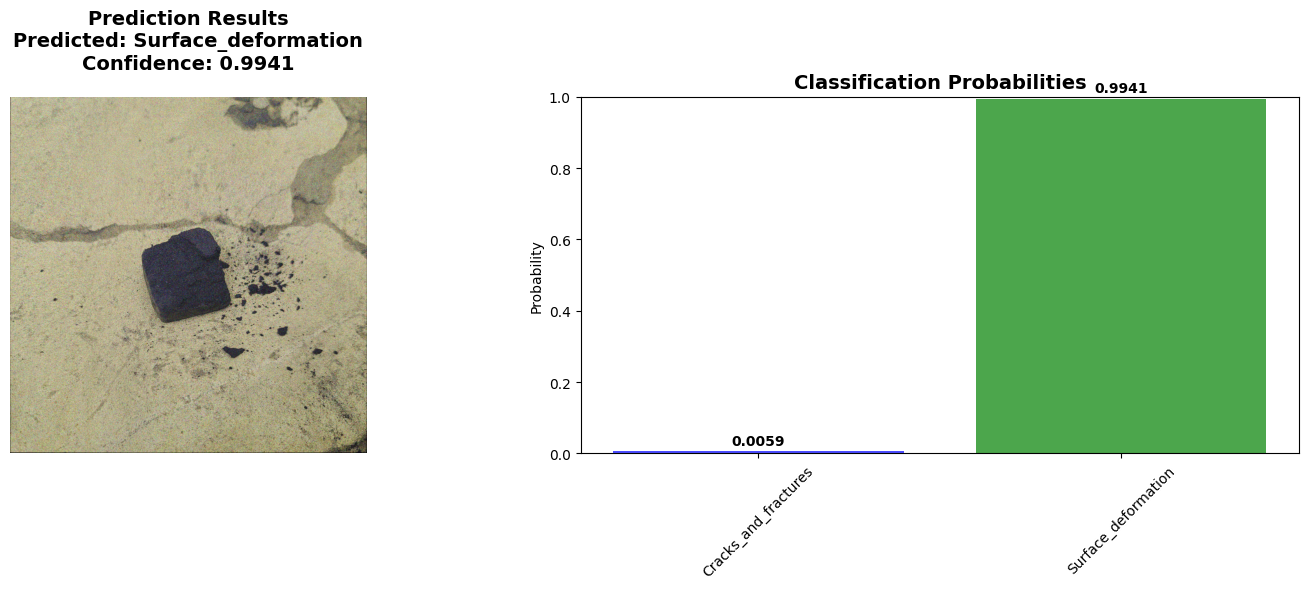


📋 PREDICTION RESULTS
📷 Image: 20251012_093958_aug_3.jpg
🎯 Predicted Class: Surface_deformation
📈 Confidence: 0.9941

📊 Probabilities:
   Cracks_and_fractures: 0.0059
   Surface_deformation: 0.9941
👋 Thank you for using Coal Classification Testing!


In [8]:
# Batch test from directory
def test_batch_from_directory(directory_path, model, class_names):
    """
    Test model on all images in a directory
    """
    if not os.path.exists(directory_path):
        print(f"❌ Error: Directory '{directory_path}' not found!")
        return
    
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    image_files = [f for f in os.listdir(directory_path) 
                  if f.lower().endswith(image_extensions)]
    
    if not image_files:
        print(f"❌ No images found in directory '{directory_path}'")
        return
    
    print(f"📁 Found {len(image_files)} images in directory")
    print("⏳ Processing images...")
    
    results = []
    
    for i, image_file in enumerate(image_files, 1):
        image_path = os.path.join(directory_path, image_file)
        try:
            image = Image.open(image_path).convert('RGB')
            predicted_class, confidence, probabilities = predict_image(image, model, class_names)
            
            results.append({
                'filename': image_file,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'probabilities': probabilities
            })
            
            print(f"  {i}/{len(image_files)}: {image_file} → {predicted_class} (Confidence: {confidence:.4f})")
            
        except Exception as e:
            print(f"❌ Error processing {image_file}: {e}")
    
    # Display summary
    print("\n" + "="*60)
    print("📊 BATCH TESTING SUMMARY")
    print("="*60)
    for class_name in class_names:
        count = sum(1 for r in results if r['predicted_class'] == class_name)
        print(f"   {class_name}: {count} images")
    
    if results:
        avg_confidence = sum(r['confidence'] for r in results) / len(results)
        print(f"   Average Confidence: {avg_confidence:.4f}")
    print("="*60)
    
    return results

# Main interface
def main():
    """
    Main testing interface
    """
    print("="*70)
    print("🔍 COAL CLASSIFICATION TESTING")
    print("="*70)
    
    # Model selection
    print("\n📋 Select Model Type:")
    print("   1. Defect Type Classification (Cracks_and_fractures vs Surface_deformation)")
    print("   2. Coal Quality Classification (Good_quality_coal vs Defect_coal)")
    
    model_choice = input("🎯 Enter your choice (1 or 2): ").strip()
    
    if model_choice == '1':
        model_type = 'defect'
        default_model = 'coal_defect_classification_best.pth'
    elif model_choice == '2':
        model_type = 'quality'
        default_model = 'coal_quality_model.pth'
    else:
        print("❌ Invalid choice!")
        return
    
    # Get model path
    model_path = input(f"📁 Enter model path (default: {default_model}): ").strip()
    if not model_path:
        model_path = default_model
    
    # Load model
    model, class_names = load_model(model_path, model_type)
    if model is None:
        return
    
    # Main testing loop
    while True:
        print(f"\n🎮 Testing Options for {model_type} classification:")
        print("   1. Test single image from file")
        print("   2. Test multiple images from directory")
        print("   3. Test using camera")
        print("   4. Exit")
        
        choice = input("🎯 Enter your choice (1-4): ").strip()
        
        if choice == '1':
            image_path = input("📁 Enter image file path: ").strip()
            test_from_file(image_path, model, class_names)
            
        elif choice == '2':
            directory_path = input("📁 Enter directory path: ").strip()
            test_batch_from_directory(directory_path, model, class_names)
            
        elif choice == '3':
            test_from_camera(model, class_names)
            
        elif choice == '4':
            print("👋 Thank you for using Coal Classification Testing!")
            break
            
        else:
            print("❌ Invalid choice! Please try again.")
        
        # Continue?
        if choice != '4':
            cont = input("\n🔄 Would you like to perform another test? (y/n): ").strip().lower()
            if cont != 'y':
                print("👋 Thank you for using Coal Classification Testing!")
                break

# Quick test function
def quick_test(image_path, model_path, model_type='defect'):
    """
    Quick test function for single image
    """
    model, class_names = load_model(model_path, model_type)
    if model is None:
        return
    
    if os.path.isdir(image_path):
        test_batch_from_directory(image_path, model, class_names)
    else:
        test_from_file(image_path, model, class_names)

# Example usage
if __name__ == "__main__":
    # Run the main interface
    main()
    
    # Example quick usage (uncomment to use):
    # quick_test("path/to/coal_image.jpg", "coal_defect_classification_best.pth", "defect")
    # quick_test("path/to/images/folder", "coal_quality_model.pth", "quality")

✅ Model loaded successfully: defect classification
📊 Classes: ['Cracks_and_fractures', 'Surface_deformation']
📁 Loading image: 20251012_094321_aug_4.jpg


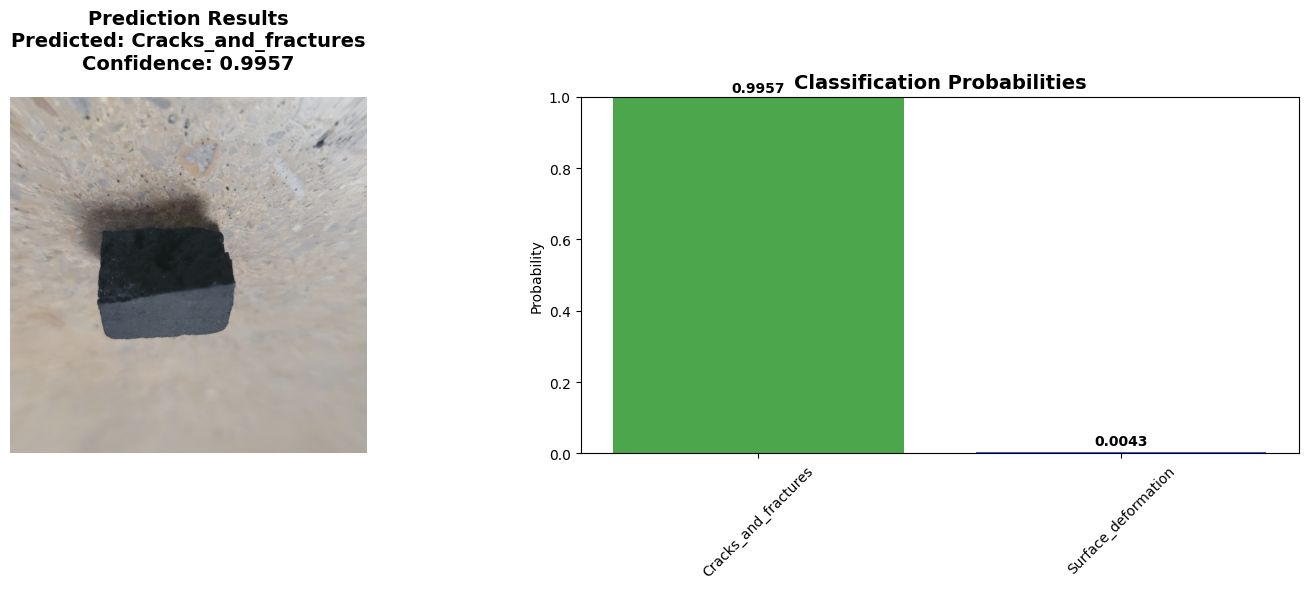


📋 PREDICTION RESULTS
📷 Image: 20251012_094321_aug_4.jpg
🎯 Predicted Class: Cracks_and_fractures
📈 Confidence: 0.9957

📊 Probabilities:
   Cracks_and_fractures: 0.9957
   Surface_deformation: 0.0043
✅ Model loaded successfully: quality classification
📊 Classes: ['Defect_coal', 'Good_quality_coal']
📁 Loading image: 20251012_100057.jpg


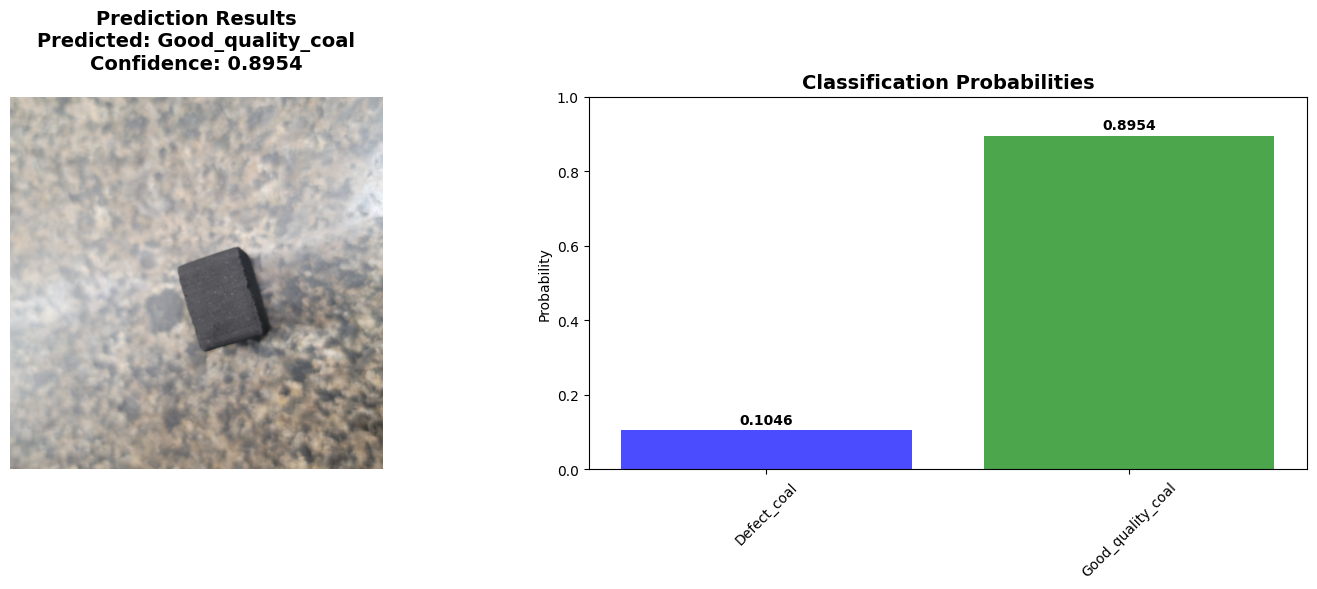


📋 PREDICTION RESULTS
📷 Image: 20251012_100057.jpg
🎯 Predicted Class: Good_quality_coal
📈 Confidence: 0.8954

📊 Probabilities:
   Defect_coal: 0.1046
   Good_quality_coal: 0.8954


In [9]:
quick_test(r"E:\AI Deep learning\coal_project\project2_largdata_coal\coal_defect_classification\Cracks_and_fractures\20251012_094321_aug_4.jpg", "coal_defect_classification_best.pth", "defect")

# Test folder of images with quality classification
quick_test(r"E:\AI Deep learning\coal_project\project2_largdata_coal\coal_data\val\Good_quality_coal\20251012_100057.jpg", "coal_quality_model.pth", "quality")